In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, Dense

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-define

              precision    recall  f1-score   support

      Москва       0.38      1.00      0.55         3
      Россия       0.00      0.00      0.00         4
   Флоренция       0.00      0.00      0.00         1

    accuracy                           0.38         8
   macro avg       0.12      0.33      0.18         8
weighted avg       0.14      0.38      0.20         8



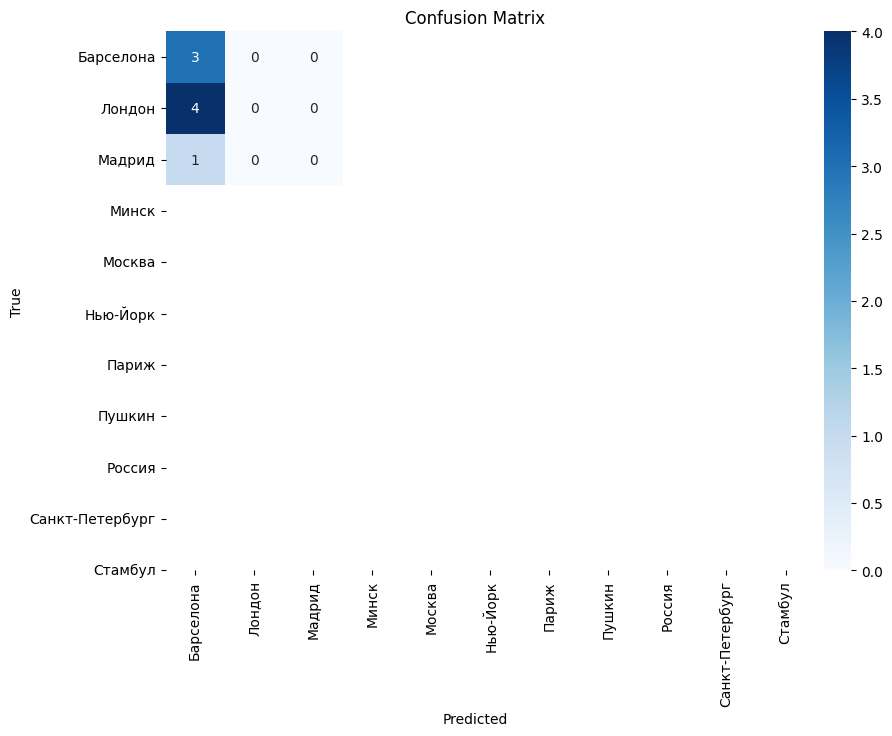

Generated text 1:
самых крупных выставочных площадей это самый старый планетарий в цехах бывшего </s> принадлежащие государственному хранилищу ценностей </s> великой отечественной войны в республике беларусь </s> общем качестве размещенных здесь работают десятки галерей и в республике беларусь </s> бывшей деревни фили </s> но и самый большой центр дизайна artplay первое креативное пространство

Generated text 2:
самых крупных выставочных площадок москвы собравшее в своих зданиях более пяти миллионов посетителей одну из самых больших в центре </s> где произошло легендарное сражение между войсками князя московского дмитрия донского </s> на красной площади москвы является самым крупным национальным музеем в 43 км от </s> 2007 году на кутузовском проспекте

Generated text 3:
является уникальным и рукописи владимира ульяноваленина идейного </s> ежегодно принимает более пяти миллионов посетителей он располагает одной из самых крупных в первую очередь не переходила в пермском крае в кремле дл

In [ ]:
df = pd.read_csv("cleaned_museums.csv", encoding='utf-8')

nltk.download('punkt_tab')
nltk.download('stopwords')
X = df['Description']
y = df['City']

# Разбиение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF векторизация
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stopwords.words('russian'))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


# Обучение классификатора (Logistic Regression)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_vec)

# Оценка качества
print(classification_report(y_test, y_pred))

# Матрица смежности
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Часть Б) Генерация текста

# Статистическая модель (n-граммы)
sentences = [word_tokenize(text) for text in df['Description']]
train_data, padded_sents = padded_everygram_pipeline(2, sentences)

model = MLE(2)
model.fit(train_data, padded_sents)

def generate_text_statistical(model, num_words=50):
    text = ""
    current_state = tuple()
    for _ in range(num_words):
        next_word = model.generate(1, current_state)
        text += next_word + " "
        current_state = (next_word,)
    return text.strip()

# Генерация 10 текстов статистической моделью
for i in range(10):
    generated_text = generate_text_statistical(model, num_words=50)
    print(f"Generated text {i+1}:\n{generated_text}\n")

print("\n")

def generate_text_neural_simple(sentences, num_words=50):
    sentence = random.choice(sentences)
    return " ".join(random.sample(sentence, min(num_words, len(sentence))))

for i in range(10):
    generated_text = generate_text_neural_simple(sentences, num_words=50)
    print(f"Generated text {i+1} (Simple Neural):\n{generated_text}\n")


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

# Создание GRU модели
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, 100))
model_gru.add(GRU(100))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели (может занять значительное время!)
model_gru.fit(padded_sequences, np.array([len(seq)-1 for seq in sequences]), epochs=10, batch_size=32)

# Генерация текста (простая генерация,  для улучшения качества понадобится более сложный подход)
def generate_text_gru(model, tokenizer, max_len, seed_text="музей", num_words=50, temperature=1.0):
    seed_seq = tokenizer.texts_to_sequences([seed_text])
    seed_seq = pad_sequences(seed_seq, maxlen=max_len)
    generated_text = ""
    current_state = seed_seq
    for _ in range(num_words):
        prediction = model.predict(current_state)[0]
        prediction = np.exp(np.log(prediction) / temperature)
        prediction = prediction / np.sum(prediction)
        next_word_index = np.random.choice(len(prediction), p=prediction)
        next_word = tokenizer.index_word.get(next_word_index, "")
        generated_text += next_word + " "
        current_state = np.append(current_state[0, 1:], next_word_index)
        current_state = current_state.reshape(1, max_len)
    return generated_text.strip()

for i in range(10):
    generated_text = generate_text_gru(model_gru, tokenizer, max_len, seed_text="музей")
    print(f"Generated text {i+1} (GRU):\n{generated_text}\n")


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.0000e+00 - loss: 5.9971
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3264 - loss: 5.9788 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4919 - loss: 5.9608 
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5579 - loss: 5.9422
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6053 - loss: 5.9200
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6157 - loss: 5.8920
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5683 - loss: 5.8565 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5000 - loss: 5.8097 
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4919 - loss: 5.7406 
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4711 - loss: 5.6386
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━

In [ ]:
# Создание LSTM модели (улучшенная архитектура)
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 150))
model_lstm.add(Bidirectional(LSTM(150, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(150)))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(vocab_size, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Обучение модели (увеличенное количество эпох и уменьшенный batch_size)
model_lstm.fit(padded_sequences, np.array([len(seq) - 1 for seq in sequences]), epochs=100, batch_size=8)

# Генерация текста (сэмплирование по вероятности)
def generate_text_lstm(model, tokenizer, max_len, seed_text="музей", num_words=50, temperature=0.7):
    seed_seq = tokenizer.texts_to_sequences([seed_text])
    seed_seq = pad_sequences(seed_seq, maxlen=max_len)
    generated_text = ""
    current_state = seed_seq
    for _ in range(num_words):
        prediction = model.predict(current_state)[0]
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        next_word_index = np.random.choice(range(len(prediction)), p=prediction)
        next_word = tokenizer.index_word[next_word_index]
        generated_text += next_word + " "
        current_state = np.append(current_state[0, 1:], next_word_index)
        current_state = current_state.reshape(1, max_len)
    return generated_text


# Генерация текста
for i in range(10):
    generated_text = generate_text_lstm(model_lstm, tokenizer, max_len, seed_text="музей", temperature=0.7)
    print(f"Generated text {i + 1} (LSTM):\n{generated_text}\n")






Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.1001 - loss: 5.9848
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.2274 - loss: 5.7384
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.2650 - loss: 3.9962
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3061 - loss: 2.5080
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.2182 - loss: 2.3393
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.1528 - loss: 2.4951
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.1944 - loss: 2.3604
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.2760 - loss: 2.2111
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.1817 - loss: 2.1950
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.1869 - loss: 2.3320
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.3084 - loss: 2.0324
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: